### Import packages

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             
from numpy.random import choice

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [2]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lijnen.csv", sep=";")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(str(x).replace(',','.')))
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(str(x).replace(',','.')))

In [3]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [4]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

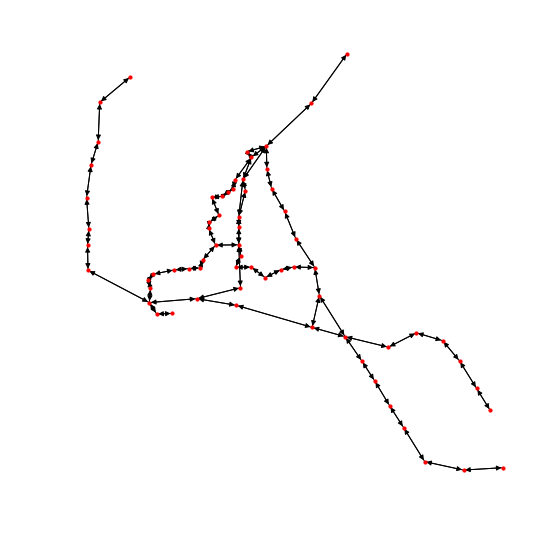

In [5]:
# Plot the network
plt.figure(figsize=(7,7)) 
# nx.draw(FG, positions, node_size=10, with_labels=True, font_size=10)
nx.draw(FG, positions, node_size=10)

### Route calculation and choice functions

In [6]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["waiting"] = int(random.random() * 10)
    route_info["duration"] += (route_info["transfers"] * 3)
    
    return route_info

In [7]:
def route_choice(routes, classname):
    if classname == 0:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["transfers"] < routes[index][0]["transfers"]:
                    index = i

    elif classname == 1:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create and spawn vehicles

In [8]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

In [9]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        vehicle = generate_vehicle(lines[name][x], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(frequency * 60)

### Generate passengers based on data

In [16]:
origin = pd.read_csv("Data/origin.csv")
destination = pd.read_csv("Data/destination.csv")

gvborigin = {}
gvbdestination = {}

hours = list(set(origin['hour'].tolist()))

for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    sums = df['sum'].tolist()
    total = df['sum'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(sums[i]/total)
        
    gvborigin[hour[:2]] = (total, stops, percentages)
    
for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    sums = df['sum'].tolist()
    total = df['sum'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(sums[i]/total)
        
    gvbdestination[hour[:2]] = (total, stops, percentages)

In [22]:
origin

,hour,stop,min,median,sum,max,mean
0,00:00 - 00:59,Amsteldijk,25,25.0,25,25,0.735294
1,00:00 - 00:59,Amstelstation,28,43.0,1509,65,44.382353
2,00:00 - 00:59,Amstelveenseweg,11,13.0,45,21,1.323529
3,00:00 - 00:59,Bullewijk,10,13.0,149,26,4.382353
4,00:00 - 00:59,Burg.de Vlugtlaan,10,12.5,48,13,1.411765
5,00:00 - 00:59,Centraal Station,65,139.0,21893,972,643.911765
6,00:00 - 00:59,Dam,10,72.0,7279,304,214.088235
7,00:00 - 00:59,De Pijp,10,37.0,1645,115,48.382353
8,00:00 - 00:59,Europaplein,10,13.0,308,44,9.058824
9,00:00 - 00:59,Gaasperplas,15,15.0,15,15,0.441176


In [21]:
gvborigin['00']

(66779,
 ['Amsteldijk',
  'Amstelstation',
  'Amstelveenseweg',
  'Bullewijk',
  'Burg.de Vlugtlaan',
  'Centraal Station',
  'Dam',
  'De Pijp',
  'Europaplein',
  'Gaasperplas',
  'Heemstedestraat',
  'Henk Sneevlietweg',
  'Isolatorweg',
  'Jan v.Galenstraat',
  'Keizersgracht',
  'Koningsplein',
  'Kraaienneststation',
  'Leidseplein',
  'Muntplein',
  'Museumplein',
  'Nieuwezijds Kolk',
  'Nieuwmarkt',
  'Noord',
  'Noorderpark',
  'Overamstel',
  'Prinsengracht',
  'Reigersbos',
  'Rijksmuseum',
  'Rokin',
  'Spaklerweg',
  'Spui',
  'Station Bijlmer ArenA',
  'Station Diemen-Zuid',
  'Station Duivendrecht',
  'Station Holendrecht',
  'Station Lelylaan',
  'Station RAI',
  'Station Sloterdijk',
  'Station Zuid',
  'Strandvliet',
  'Van Baerlestraat',
  'Van der Madeweg',
  'Venserpolder',
  'Vijzelgracht',
  'Waterlooplein',
  'Weesperplein',
  'Wibautstraat'],
 [0.00037436918791835757,
  0.022596924182752064,
  0.0006738645382530436,
  0.002231240359993411,
  0.0007187888408032

In [11]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        routes.append(((route_calculation(path, FG)), path))
        
    # Travel direction and route information
    route_info, route = route_choice(routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [12]:
def passengers(env, classname, origindata, destinationdata):
    # Store number of passengers, origin data and destination data
    # for the hour in a variable
    hour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
    numpassengers = origindata[hour][0]
    originstations = origindata[hour][1]
    originprobabilities = origindata[hour][2]
    
    destinationstations = destinationdata[hour][1]
    destinationprobabilities = destinationdata[hour][2]

    while True:
        newhour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
        if newhour == hour:
            origin = (choice(originstations, 1, p=originprobabilities))[0]
            destination = (choice(destinationstations, 1, p=destinationprobabilities))[0]
            
            # Run again if origin and destination are the same
            while origin == destination:
                origin = choice(originstations, 1, p=originprobabilities)[0]
                destination = choice(destinationstations, 1, p=destinationprobabilities)[0]

            # Create passenger and add to simulation
            passenger = generate_passenger(origin, destination, classname, env)
            FG.nodes[origin]["object_type"].units.append(passenger)
            passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                                env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
            env.passengers.append(passenger)

            # Calculate timeout based on arrival rate
            timeout = (60*60) / numpassengers
            yield env.timeout(random.random() * timeout)
            
        # If the hour is exceeded, update variables for the next hour
        else:
            hour = newhour
            numpassengers = origindata[hour][0]
            originstations = origindata[hour][1]
            originprobabilities = origindata[hour][2]

            destinationstations = destinationdata[hour][1]
            destinationprobabilities = destinationdata[hour][2]

### Run simulation

In [13]:
# Get total passengers per hour
# Get arrival rate based on this number > what should the timeout be between arrivals to get 
# to this number of passengers for this hour (e.g. number / 60 seconds) 
# Calculate an origin based on chance
# Calculate a destination based on chance
# Simulation works as before
# When the end time of the block is met, begin this again

# dict format origin (seperate for dest): {00:00 - 00:59: {'Centraal Station': (0.5714, 400), 'Rokin': (0.428, 300)}}
# get sum of inner dict values = 700
# get chances for all stations

# check here the number of transfers maybe? 3 transfers is unrealistic > so not include

In [18]:
# Simulation start time
simulation_start = datetime.datetime(2018, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []

# Start the simulation
# env.process(vehicle(env, 0, 10, "metro50", 0))
# env.process(vehicle(env, 0, 10, "metro50", 1))
# env.process(vehicle(env, 0, 10, "metro51", 0))
# env.process(vehicle(env, 0, 10, "metro51", 1))
# env.process(vehicle(env, 0, 10, "metro52", 0))
# env.process(vehicle(env, 0, 10, "metro52", 1))
# env.process(vehicle(env, 0, 10, "metro53", 0))
# env.process(vehicle(env, 0, 10, "metro53", 1))
# env.process(vehicle(env, 0, 10, "metro54", 0))
# env.process(vehicle(env, 0, 10, "metro54", 1))
# env.process(vehicle(env, 0, 10, "tram12", 0))
# env.process(vehicle(env, 0, 10, "tram12", 1))
# env.process(vehicle(env, 0, 10, "tram24", 0))
# env.process(vehicle(env, 0, 10, "tram24", 1))

# env.process(passengers(origin, destination, classname, env))
env.process(passengers(env, 0, gvborigin, gvbdestination))
env.run(until = env.now + 1 * 60 * 10)

KeyboardInterrupt: 

### Check results

In [19]:
len(env.passengers)

8364

In [83]:
pd.DataFrame.from_dict(env.vehicles[4].log)

,Message,Timestamp,Value,Geometry
0,Driving from node Noord to node Noorderpark start,2019-01-01 00:00:00,0,POINT (52.40117202 4.93123182)
1,Driving from node Noord to node Noorderpark stop,2019-01-01 00:02:00,0,POINT (52.38855518 4.91789115)
2,Unloading start,2019-01-01 00:02:00,0,POINT (52.38855518 4.91789115)
3,Unloading stop,2019-01-01 00:02:00,30,POINT (52.38855518 4.91789115)
4,Driving from node Noorderpark to node Centraal...,2019-01-01 00:02:30,0,POINT (52.38855518 4.91789115)
5,Driving from node Noorderpark to node Centraal...,2019-01-01 00:04:30,0,POINT (52.37771998 4.90104337)
6,Unloading start,2019-01-01 00:04:30,0,POINT (52.37771998 4.90104337)
7,Unloading stop,2019-01-01 00:04:30,30,POINT (52.37771998 4.90104337)
8,Driving from node CentraalStation to node Roki...,2019-01-01 00:05:00,0,POINT (52.37771998 4.90104337)
9,Driving from node CentraalStation to node Roki...,2019-01-01 00:07:00,0,POINT (52.36928023 4.89229651)


In [19]:
env.passengers[0].__dict__

{'env': <simpy.core.Environment at 0x110643fd0>,
 'log': {'Message': ['Waiting for tram24'],
  'Timestamp': [datetime.datetime(2018, 1, 1, 0, 0)],
  'Value': [0],
  'Geometry': [<shapely.geometry.point.Point at 0x115daf7b8>]},
 'route': ['IJsbaanpad', 'OlympischStadion', 'Olympiaweg', 'Olympiaplein'],
 'complete_path': None,
 'route_info': {'lines': ['tram24'],
  'duration': 4,
  'transfers': 0,
  'waiting': 1,
  'transferstations': []},
 'transfers': 0,
 'transferstations': [],
 'duration': 4,
 'lines': ['tram24'],
 'class_id': 0,
 'name': 'Passenger',
 'id': '0d0b3562-7c98-11e9-8170-7831c1d08f6a'}

### Maybe omit passengers with more than 3 transfers

In [29]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
            passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route,
                                        "origin": env.passengers[i].route[0],
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'], 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
#                                         "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
#                                         "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
#                                         "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id, 
                                        "waiting_time": 0}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
# passengerdf.to_csv("Results/passengers.csv", index=True)
passengerdf

,class_id,creation,destination,lines,origin,route,transfers,transferstations,waiting_time
46983af4-7c99-11e9-a7e3-7831c1d08f6a,0,00:00:00,Strandvliet,"[metro52, metro54]",Noord,"[Noord, Noorderpark, CentraalStation, Nieuwmar...",1,[CentraalStation],0
469bc5d4-7c99-11e9-a6d2-7831c1d08f6a,0,00:00:04,Amsteldijk,"[tram24, tram12]",OlympischStadion,"[OlympischStadion, Olympiaweg, Olympiaplein, M...",1,[RoelofHartplein],0
469e7090-7c99-11e9-9414-7831c1d08f6a,0,00:00:15,IJsbaanpad,"[metro53, metro50, metro51, tram24]",Kraaienneststation,"[Kraaienneststation, StationGanzenhoef, Verrij...",3,"[VanderMadeweg, Overamstel, Amstelveenseweg]",0
46a216a8-7c99-11e9-a7c3-7831c1d08f6a,0,00:00:22,Strandvliet,"[metro51, metro54]",Heemstedestraat,"[Heemstedestraat, HenkSneevlietweg, Amstelveen...",1,[Spaklerweg],0
46a47bca-7c99-11e9-893e-7831c1d08f6a,0,00:00:23,Museumplein,"[metro54, tram12]",Reigersbos,"[Reigersbos, StationHolendrecht, Bullewijk, St...",1,[Amstelstation],0
46a81eb0-7c99-11e9-96cf-7831c1d08f6a,0,00:00:25,Gein,"[metro53, metro54]",Gaasperplas,"[Gaasperplas, Kraaienneststation, StationGanze...",1,[VanderMadeweg],0
46a94146-7c99-11e9-b094-7831c1d08f6a,0,00:00:32,RoelofHartplein,[tram12],Amstelstation,"[Amstelstation, Amsteldijk, Victorieplein, Waa...",0,[],0
46a9bacc-7c99-11e9-83ad-7831c1d08f6a,0,00:00:45,DePijp,"[metro54, tram12]",StationDuivendrecht,"[StationDuivendrecht, VanderMadeweg, Spaklerwe...",1,[Amstelstation],0
46add3be-7c99-11e9-80ce-7831c1d08f6a,0,00:00:59,Noord,"[tram24, metro51, metro52]",OlympischStadion,"[OlympischStadion, IJsbaanpad, Amstelveenseweg...",2,"[Amstelveenseweg, Zuid]",0
46b16812-7c99-11e9-9da3-7831c1d08f6a,0,00:01:10,Reigersbos,"[metro51, metro54]",Isolatorweg,"[Isolatorweg, StationSloterdijk, BurgdeVlugtla...",1,[Spaklerweg],0


In [31]:
passengerdf

""


In [21]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
# vehicledf.to_csv("Results/vehicles.csv", index=True)

In [22]:
vehicledf

""
